In [1]:
import numpy as np
import pandas as pd
from numpy import linalg as nplin
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')

In [3]:
logging.basicConfig(filename='convergence.tmp.log', level=logging.INFO)
logging.captureWarnings(True)

## Setup the True Parameters /  Simulation Parameters

## Setup the linking functions.

In [4]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.gamma(rho=true_params['rho'], scale=true_params['scale'], delta=true_params['delta'], 
                       phi=true_params['phi'], pi=true_params['vol_price'], theta=true_params['equity_price']),
     'beta':vl.beta(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                    pi=true_params['vol_price'], theta=true_params['equity_price']),
     'psi':vl.psi(true_params['rho'], true_params['scale'], true_params['phi'], 
                  theta=true_params['equity_price']), 
     'phi_squared': true_params['phi']**2})

NameError: name 'true_params' is not defined

## We start by examining the distributions of simulated data

In [ ]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [ ]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return')
ax1.plot(data.vol, label='Volatility')
ax1.legend()


In [ ]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [ ]:
data.describe()

## I now estimate all of the parameters

In [26]:
true_params = {'equity_price': 0.50, 
               'vol_price': -7,
               'phi':-.17,
               'scale': .1,
               'delta': 1,
               'rho': 0,
              }
time_dim = 3000
sim_dim = 1000

In [27]:
results = np.arange(sim_dim)

In [28]:
data = vl.simulate_data(time_dim=time_dim, **true_params)


In [29]:
vol_data = vl.simulate_autoregressive_gamma(delta=1, rho=0, scale=1,time_dim=time_dim)


In [132]:
def get_data_and_results(x):
    data = vl.simulate_data(time_dim=time_dim, **true_params)
    init_constants = vl.compute_init_constants(data.vol)
    vol_est = vl.compute_vol_gmm(data.vol, init_constants=init_constants)
    return data, vol_est

In [146]:
with Pool(8) as pool:
    data_arr, est_arr = zip(*[result  for result in tqdm.tqdm_notebook(
        pool.imap_unordered(get_data_and_results, results), total=len(results))])

Process ForkPoolWorker-27:
Process ForkPoolWorker-30:
Process ForkPoolWorker-26:
Process ForkPoolWorker-25:
Process ForkPoolWorker-29:
Process ForkPoolWorker-28:
Process ForkPoolWorker-31:
Traceback (most recent call last):
Process ForkPoolWorker-32:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/sangrey/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/sangrey/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/sangrey/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/sangrey/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  

KeyboardInterrupt
  File "/home/sangrey/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sangrey/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py", line 942, in rvs
    if np.all(scale == 0):
  File "/home/sangrey/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py", line 2809, in rvs
    return super(rv_discrete, self).rvs(*args, **kwargs)
  File "/home/sangrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py", line 1973, in all
    def all(a, axis=None, out=None, keepdims=np._NoValue):
  File "/home/sangrey/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py", line 937, in rvs
    args, loc, scale, size = self._parse_args_rvs(*args, **kwds)
  File "/home/sangrey/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
KeyboardInterrupt
  File "<ipython-input-132-1e67

KeyboardInterrupt: 

In [145]:
vl.simulate_data(time_dim=time_dim, **true_params).head()

,vol,rtn
2000-01-01,0.211803,0.476651
2000-01-02,0.010593,0.129141
2000-01-03,0.067151,-0.276689
2000-01-04,0.112376,-0.607147
2000-01-05,0.015091,-0.088449


In [147]:
data_arr[1].head()

,vol,rtn
2000-01-01,0.008623,0.075481
2000-01-02,0.295916,0.518976
2000-01-03,0.054126,0.467144
2000-01-04,0.057599,-0.460065
2000-01-05,0.015831,0.032859


In [149]:
data_arr[0].head()

,vol,rtn
2000-01-01,0.008623,0.075481
2000-01-02,0.295916,0.518976
2000-01-03,0.054126,0.467144
2000-01-04,0.057599,-0.460065
2000-01-05,0.015831,0.032859


In [33]:
true_params['rho']

0

In [34]:
np.mean((data.vol - true_params['delta'] * true_params['scale']) * data.vol)

0.010435992265701787

In [35]:
np.mean((data.vol[1:]**2 - true_params['delta'] * true_params['scale']**2 
         - true_params['delta']**2 * true_params['scale']**2))

0.0004051787723292784

In [36]:
vl.vol_moments(data.vol, delta=true_params['delta'], rho=0, scale=true_params['scale']).mean()

0   -0.000341
1   -0.000053
2    0.000406
3    0.000008
4   -0.000028
dtype: float64

In [125]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
    
    inv_cov = nplin.pinv(cov)
    
    return mean   / (np.diag(inv_cov)**(-.5) / np.sqrt(data.vol.size))
    
    

In [126]:
t_stats(vl.vol_moments(data.vol, true_params['delta'], true_params['rho'], true_params['scale']))

0   -0.565023
1   -0.705022
2    1.417043
3    0.279518
4   -2.553835
dtype: float64

In [111]:
data.vol.std()

0.10235486856372081

In [131]:
data_arr[1] - data_arr[0]

,vol,rtn
2000-01-01,0.0,0.0
2000-01-02,0.0,0.0
2000-01-03,0.0,0.0
2000-01-04,0.0,0.0
2000-01-05,0.0,0.0
2000-01-06,0.0,0.0
2000-01-07,0.0,0.0
2000-01-08,0.0,0.0
2000-01-09,0.0,0.0
2000-01-10,0.0,0.0


In [130]:
data_arr[0].head()

,vol,rtn
2000-01-01,0.008623,0.075481
2000-01-02,0.295916,0.518976
2000-01-03,0.054126,0.467144
2000-01-04,0.057599,-0.460065
2000-01-05,0.015831,0.032859


In [122]:
[(data.vol.mean() - .1) / np.sqrt(data.vol.var() / data.vol.size) for data in data_arr]

[0.20455347946161123,
 0.20455347946161123,
 0.20455347946161123,
 0.20455347946161123,
 0.20455347946161123,
 0.20455347946161123,
 0.20455347946161123,
 0.20455347946161123,
 -0.093716946680187596,
 -0.093716946680187596,
 -0.093716946680187596,
 -0.093716946680187596,
 -0.093716946680187596,
 -0.093716946680187596,
 -0.093716946680187596,
 -0.093716946680187596,
 0.19466534252189047,
 0.19466534252189047,
 0.19466534252189047,
 0.19466534252189047,
 0.19466534252189047,
 0.19466534252189047,
 0.19466534252189047,
 0.19466534252189047,
 0.22269290185836127,
 0.22269290185836127,
 0.22269290185836127,
 0.22269290185836127,
 0.22269290185836127,
 0.22269290185836127,
 0.22269290185836127,
 0.22269290185836127,
 -0.38117804561470414,
 -0.38117804561470414,
 -0.38117804561470414,
 -0.38117804561470414,
 -0.38117804561470414,
 -0.38117804561470414,
 -0.38117804561470414,
 -0.38117804561470414,
 -0.02636127282255972,
 -0.02636127282255972,
 -0.02636127282255972,
 -0.02636127282255972,
 -0.

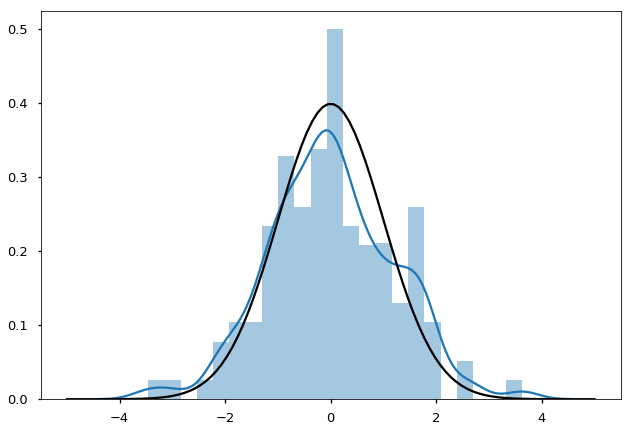

In [121]:
fig1, ax1 =  mpl.pyplot.subplots()
sns.distplot([(data.vol.mean() - .1) / np.sqrt(data.vol.var() / data.vol.size)
              for data in data_arr], ax=ax1)
ax1.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')


In [113]:
vol_moments = pd.DataFrame([t_stats(vl.vol_moments(data.vol, true_params['delta'], true_params['rho'],
                                                   true_params['scale'])) for data in data_arr])

Text(0.5,0,'delta')

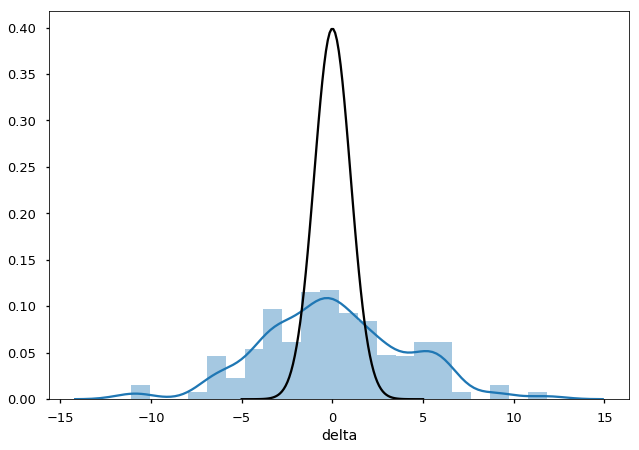

In [119]:
delta_fig, delta_ax = mpl.pyplot.subplots()
sns.distplot(vol_moments.iloc[:,0], ax=delta_ax)
delta_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
delta_ax.set_xlabel('delta')

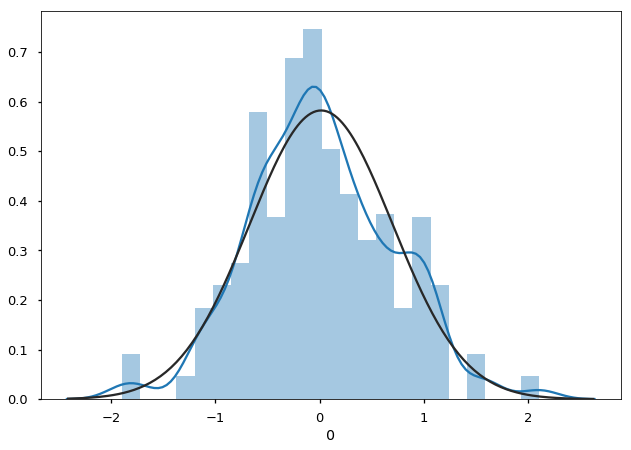

In [67]:
sns.distplot(vol_moments.iloc[:,0], fit=stats.norm)

In [ ]:
vol_moments[0]

In [ ]:
delta_fig, delta_ax = mpl.pyplot.subplots()
sns.distplot([(est['delta'] - true_params['delta']) / np.sqrt(cov.loc['delta','delta']) 
              for est, cov in est_arr], ax=delta_ax)
delta_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
delta_ax.set_xlabel('delta')

In [ ]:
scale_fig, scale_ax = mpl.pyplot.subplots()
sns.distplot([(est['scale'] - true_params['scale']) / np.sqrt(cov.loc['scale', 'scale']) 
              for est, cov in est_arr], ax=scale_ax)
scale_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
scale_ax.set_xlabel('scale')

In [ ]:
rho_fig, rho_ax = mpl.pyplot.subplots()
sns.distplot([(est['rho'] - true_params['rho']) / np.sqrt(cov.loc['rho', 'rho']) 
              for est, cov in est_arr], ax=rho_ax)
rho_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
rho_ax.set_xlabel('rho')

In [ ]:
vol_tables = [vl.create_est_table(estimates=est, truth=total_true_params, cov=cov)
                 for est,cov in vol_est_arr]

In [ ]:
pd.DataFrame([frame.truth - frame.estimate for frame in vol_tables]).mean(axis=0)

In [ ]:
stage2_estimates, stage2_cov = vl.estimate_params(data)


In [ ]:
vl.create_est_table(estimates=stage2_estimates, truth=total_true_params, cov=stage2_cov)

In [ ]:
vl.cov_to_corr(stage2_cov)